In [1]:
import numpy as np
from scipy.interpolate import CubicSpline, make_interp_spline
import matplotlib.pyplot as plt
from typing import Literal

In [2]:
BoundaryConditionType = Literal["NATURAL", "CLAMPED", "APPROX4"]

In [3]:
def get_approx(*nodes):
    n=len(nodes)

    div_diffs = [[node[1] for node in nodes]]
    for i in range(1, n):
        diffs = []
        for j in range(n - i):
            diff = (div_diffs[i - 1][j + 1] - div_diffs[i - 1][j]) / (nodes[j + i][0] - nodes[j][0])
            diffs.append(diff)
        div_diffs.append(diffs)

    return div_diffs[-2][-1]

In [4]:
def _cubic_spline(x, y, bc_type: BoundaryConditionType):
    n = len(x)
    h = [x[i+1] - x[i] for i in range(n - 1)]
    d = [(y[i+1] -y[i])/h[i] for i in range(n - 1)]
    Y = np.array([d[i+1] - d[i] for i in range(n - 2)], dtype=np.float64)
    A = np.zeros((n, n), dtype=np.float64)  # we add rows based on condition type

    for i in range(1, n-1):
        A[i][i-1] = h[i-1]
        A[i][i] = 2*(h[i-1] + h[i])
        A[i][i+1] = h[i]


    if bc_type == "APPROX4":
        y0 = h[0]**2 * get_approx(*zip(x[:4], y[:4]))
        yn = -h[-1]**2 * get_approx(*zip(x[-4:], y[-4:]))
        Y = np.concatenate(([y0], Y, [yn]), dtype=np.float64)
        A[0][0] = 1
        A[-1][-1] = 1
    elif bc_type == "NATURAL":
        Y = np.concatenate(([0], Y, [0]), dtype=np.float64)
        A[0][0] = A[-1][-2] = -h[0]
        A[0][1] = A[-1][-1] = h[0]
    else:
        raise NotImplementedError()

    s = np.linalg.solve(A, Y)
    b = [(y[i+1]-y[i])/h[i] - h[i] * (s[i+1] + 2*s[i]) for i in range(n - 1)]
    c = [3 * s[i] for i in range(n - 1)]
    d = [(s[i+1] - s[i])/h[i] for i in range(n - 1)]

    def f(x_):
        i = 0
        for j in range (len(x)-1):
            if x[j] <= x_ <= x[j + 1]:
                i=j
                break

        return y[i] + b[i] * (x_ - x[i]) + c[i] * (x_ - x[i])**2 + d[i] * (x_ - x[i])**3

    return f

In [5]:
def cubic_spline(x, y, bc_type, start, stop, n=500):
    x = np.array(x)
    y = np.array(y)

    cs = _cubic_spline(x, y, bc_type=bc_type)

    x_interp = np.linspace(start, stop, n)
    y_interp = [cs(x_) for x_ in x_interp]

    return x_interp, y_interp

In [6]:
def _square_spline(x, y, bc_type: BoundaryConditionType):
    n = len(x)
    g = [(y[i+1]-y[i])/(x[i+1]-x[i]) for i in range(n - 1)]
    A = np.zeros((n, n), dtype=np.float64)

    for i in range(1, n):
        A[i][i-1] = 1
        A[i][i] = 1

    A[0][0] = 1

    if bc_type == "NATURAL":
        y0 = 0
    elif bc_type == "CLAMPED":
        y0 = g[0]
    else:
        raise NotImplementedError


    Y = np.array([y0] + [2 * g[i] for i in range(n - 1)], dtype=np.float64)
    b = np.linalg.solve(A, Y)
    c = [(b[i+1] - b[i])/(2*(x[i+1] - x[i])) for i in range(n-1)]

    def f(x_):
        i = 0
        for j in range (len(x)-1):
            if x[j] <= x_ <= x[j + 1]:
                i=j
                break

        return y[i] + b[i] * (x_ - x[i]) + c[i] * (x_ - x[i])**2

    return f

In [7]:
def square_spline(x, y, bc_type, start, stop, n=500):
    x = np.array(x)
    y = np.array(y)

    cs = _square_spline(x, y, bc_type=bc_type)

    x_interp = np.linspace(start, stop, n)
    y_interp = [cs(x_) for x_ in x_interp]

    return x_interp, y_interp

In [8]:
def f_real(x):
    return np.exp(np.cos(x))

In [9]:
def range_evenly(start, stop, n: int):
    return np.linspace(start=start, stop=stop, num=n, dtype=np.longdouble)

In [10]:
START, STOP, N = -4 * np.pi, 4*np.pi, 500

In [11]:
x_real = range_evenly(START, STOP, N)
y_real = f_real(x_real)

In [12]:
def err(y):
    return max(abs(y-y_real))

def std_err(ys, k: int):
    s = sum([(y_r - y)**2 for y_r, y in zip(y_real, ys)])
    return 1/k * np.sqrt(s)

In [13]:
max_errors = []
std_errors = []

In [14]:
def test_spline(m: int):
    nodes_x = range_evenly(START, STOP, m)
    nodes_y = f_real(nodes_x)

    x_cubic_natural, y_cubic_natural = cubic_spline(nodes_x, nodes_y, "NATURAL", START, STOP, N)
    x_cubic_approx, y_cubic_approx = cubic_spline(nodes_x, nodes_y, "APPROX4", START, STOP, N)
    x_square_natural, y_square_natural = square_spline(nodes_x, nodes_y, "NATURAL", START, STOP, N)
    x_square_clamped, y_square_clamped = square_spline(nodes_x, nodes_y, "CLAMPED", START, STOP, N)

    #m, cubic natural, cubic approx, square natural, square clamped
    max_errors.append(
        (m, err(y_cubic_natural), err(y_cubic_approx), err(y_square_natural), err(y_square_clamped))
    )

    std_errors.append(
        (m, std_err(y_cubic_natural, N), std_err(y_cubic_approx, N), std_err(y_square_natural, N),
        std_err(y_square_clamped, N))
    )

    fig, axs = plt.subplots(2, figsize=(8, 6))
    fig.tight_layout(pad=5)
    fig.suptitle(str(m))

    for ax in axs.flat:
        ax.set(xlabel='x', ylabel='y')

    # axs[0].set_title('drugiego stopnia, warunek brzegowy nr I')
    axs[0].set_title('trzeciego stopnia, warunek brzegowy nr I')

    axs[0].plot(x_real, y_real)
    axs[0].scatter(nodes_x, nodes_y)
    axs[0].plot(x_cubic_approx, y_cubic_approx)

    axs[1].set_title('trzeciego stopnia, warunek brzegowy nr II')
    # axs[1].set_title('drugiego stopnia, warunek brzegowy nr II')
    axs[1].plot(x_real, y_real)
    axs[1].scatter(nodes_x, nodes_y)
    axs[1].plot(x_cubic_natural, y_cubic_natural)

/var/folders/68/l276bwns7pd_sdc_ys5xwgx40000gn/T/ipykernel_42183/2887299922.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, figsize=(8, 6))


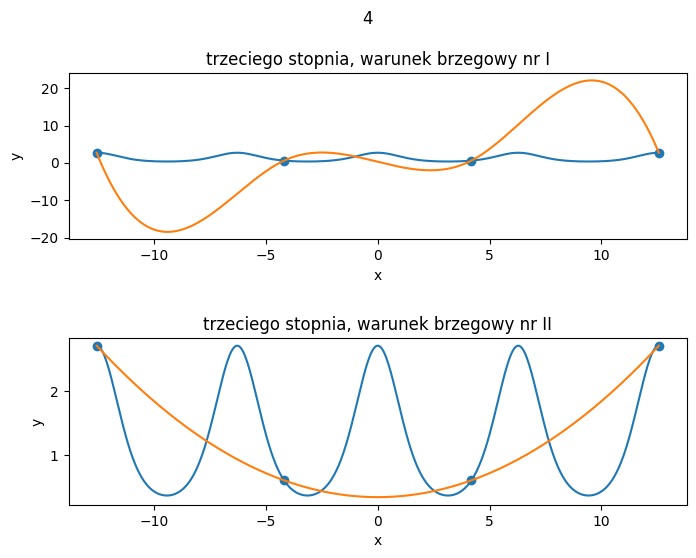

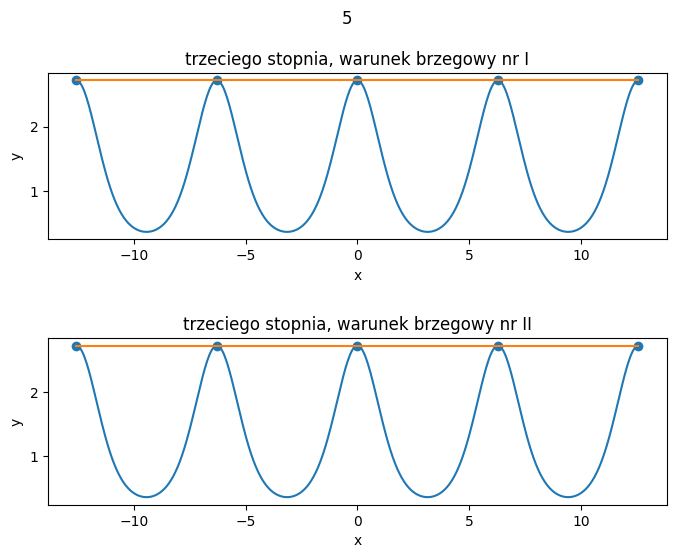

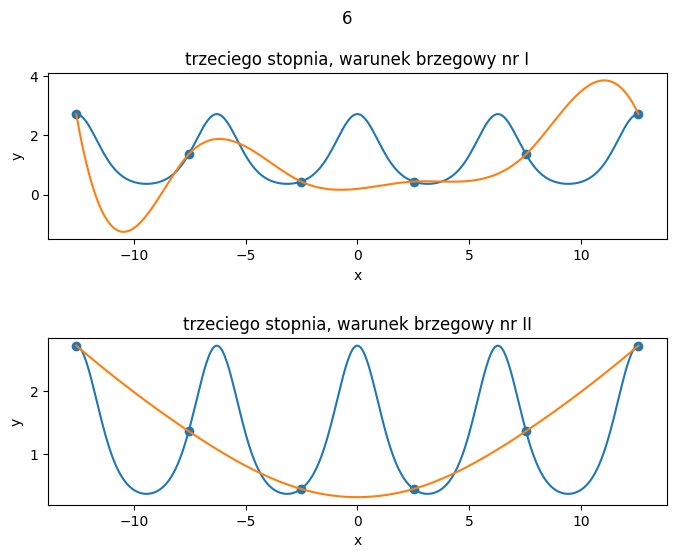

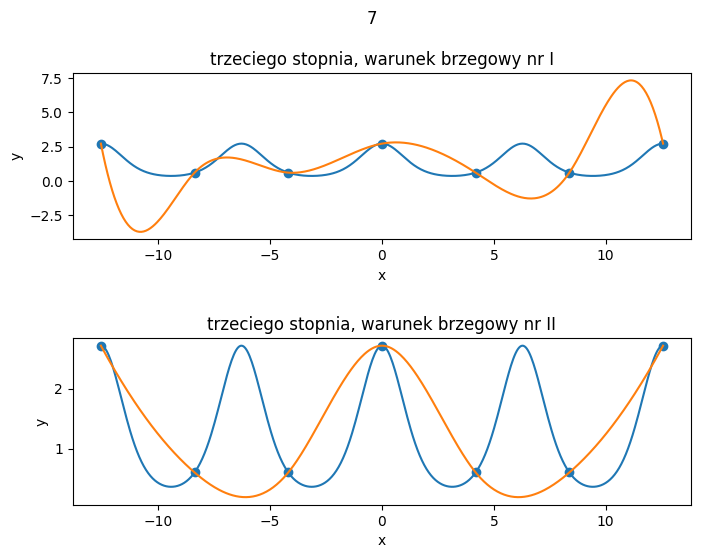

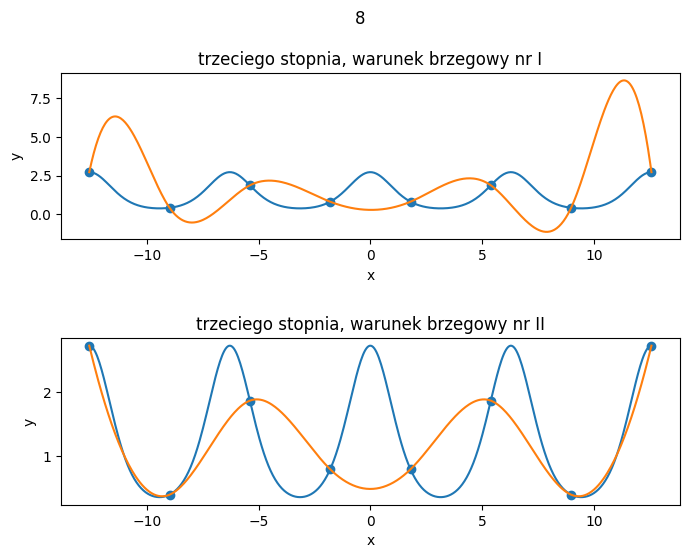

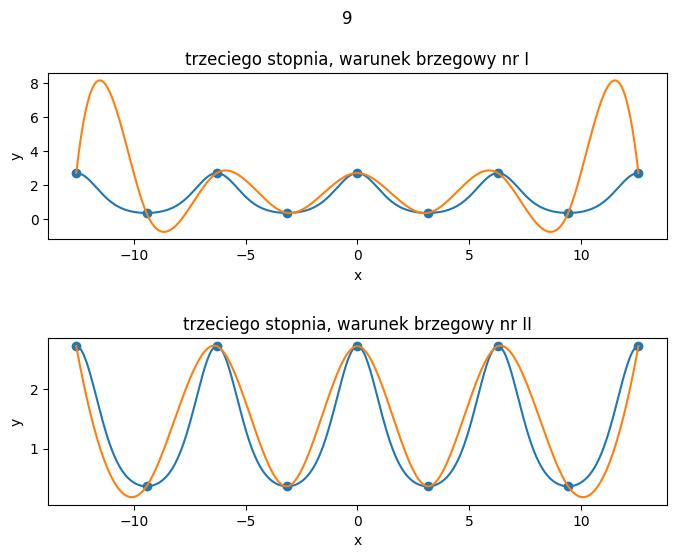

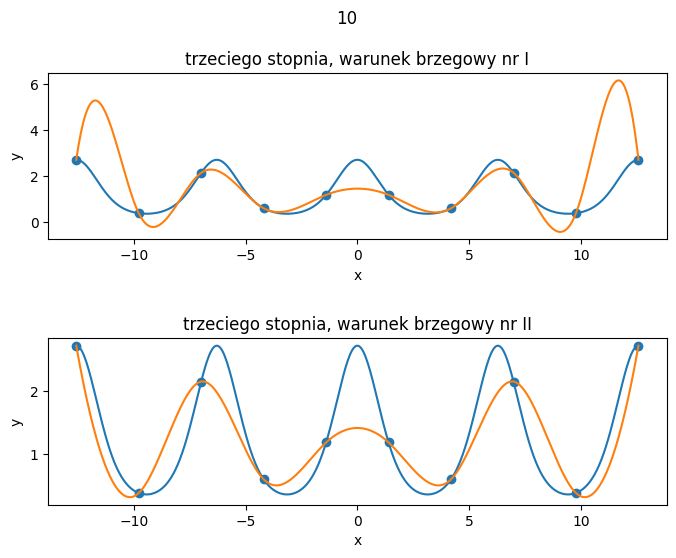

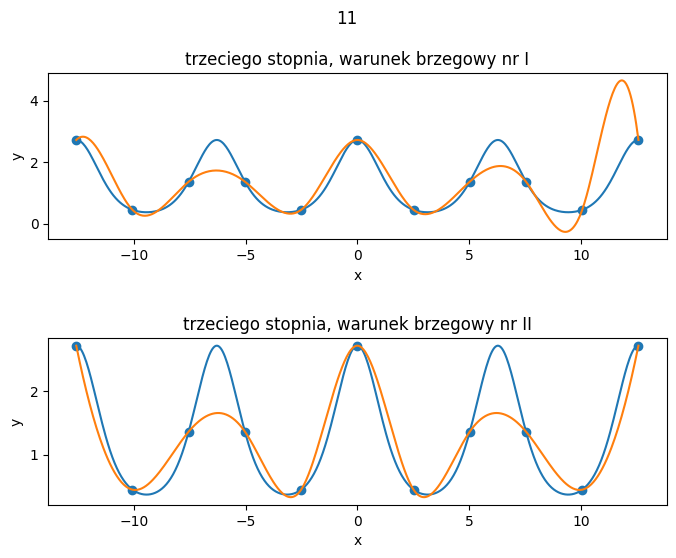

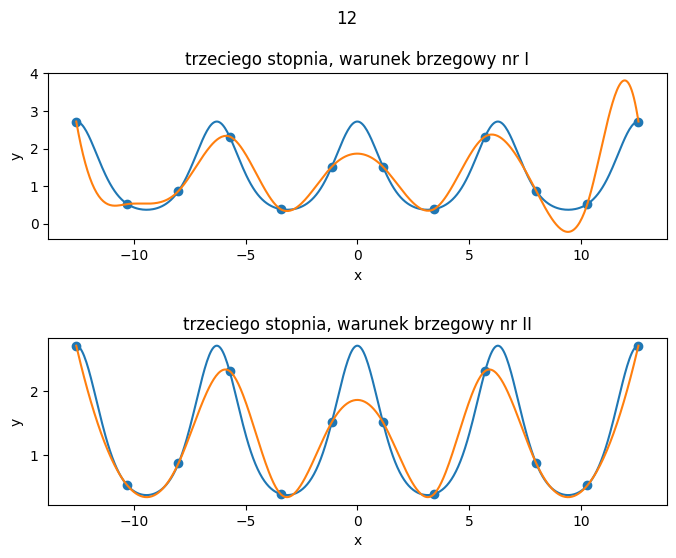

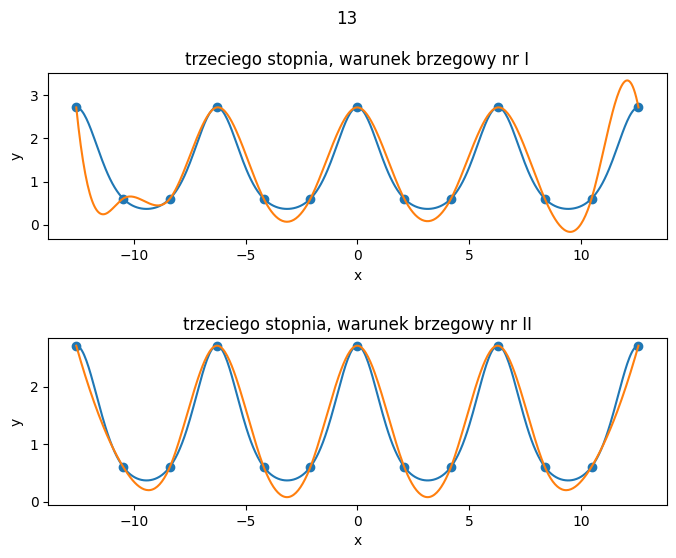

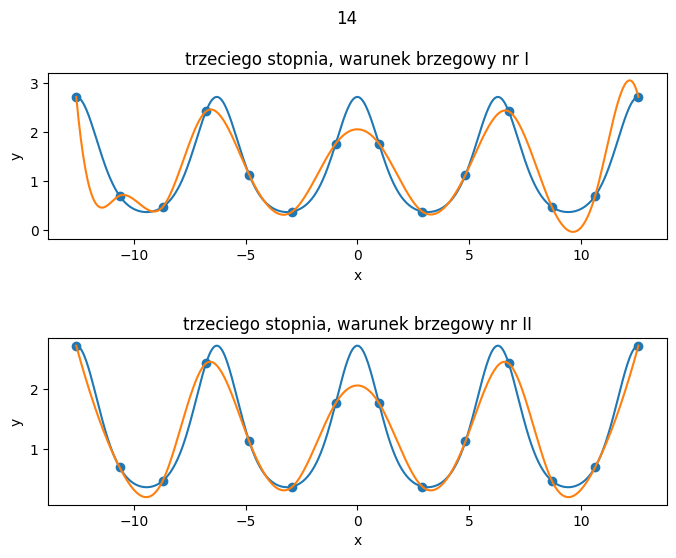

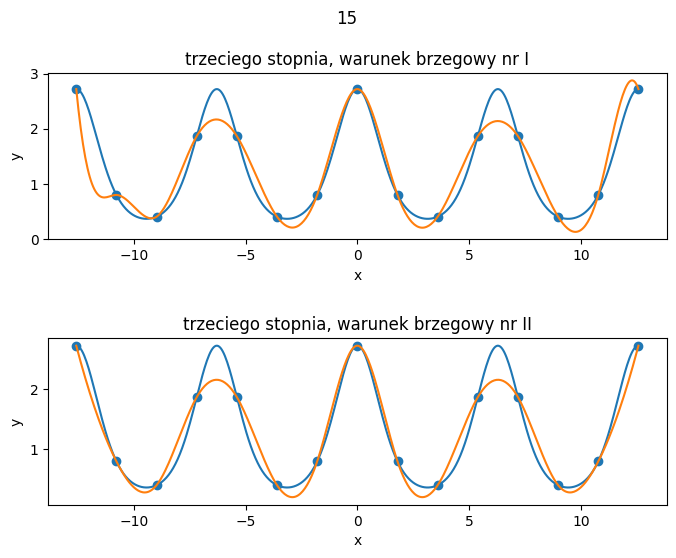

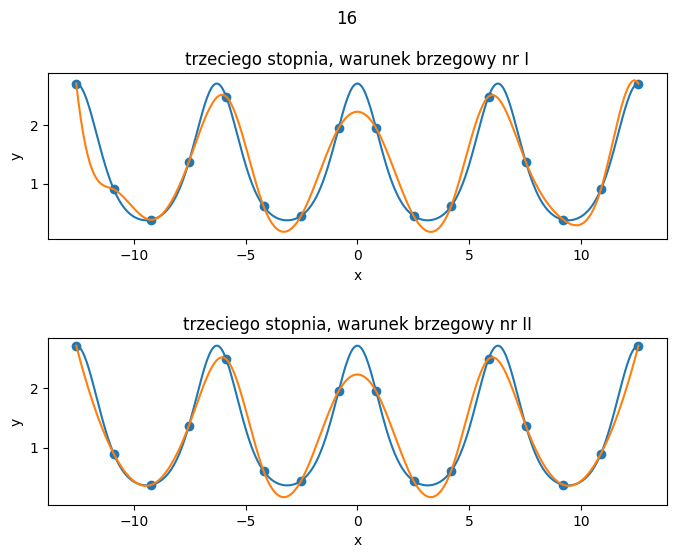

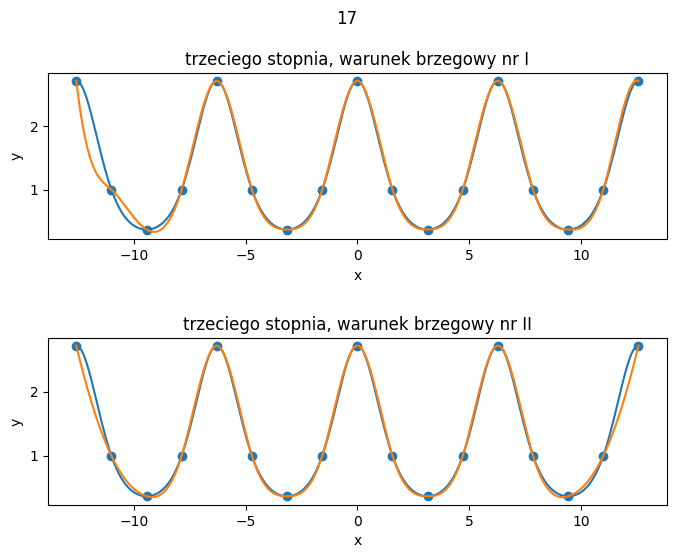

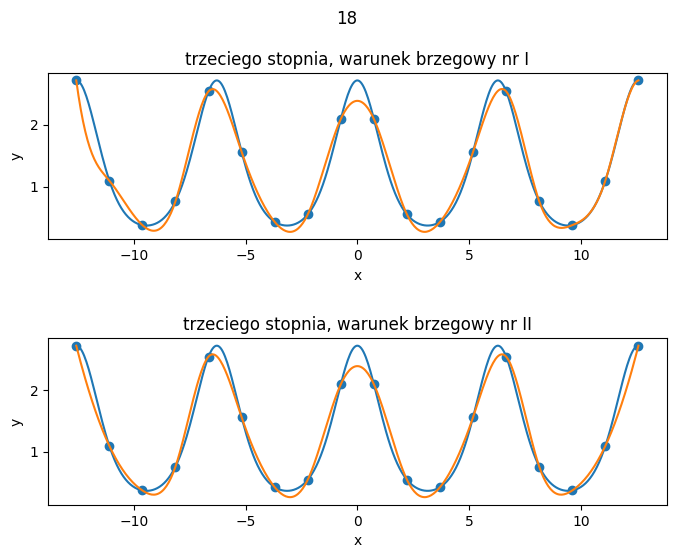

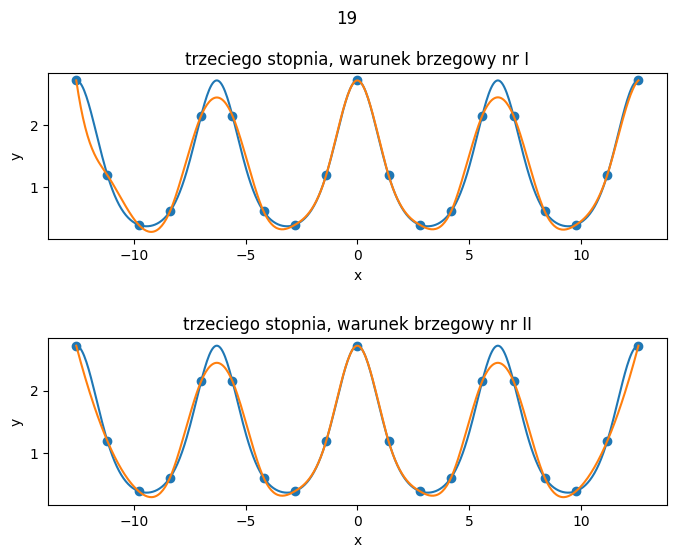

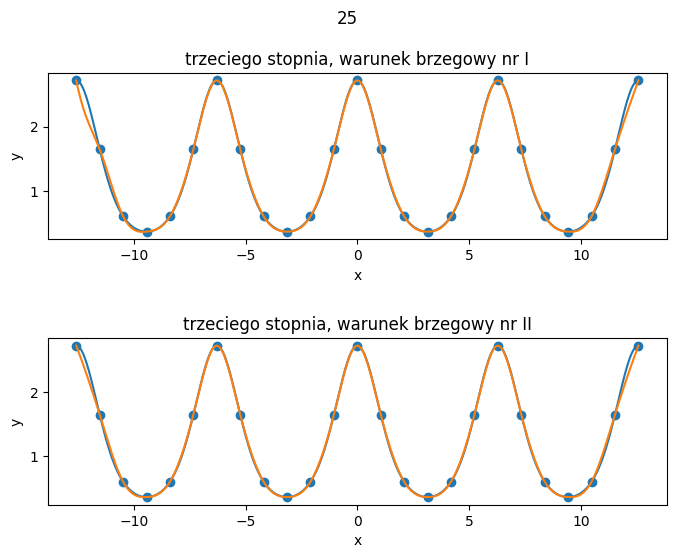

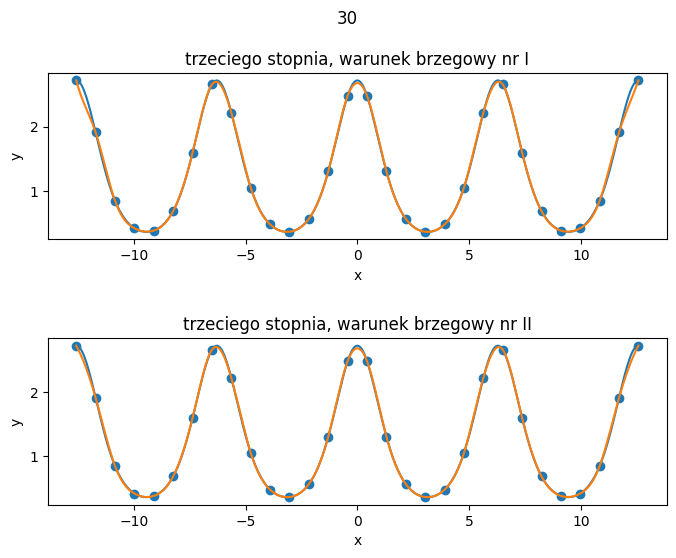

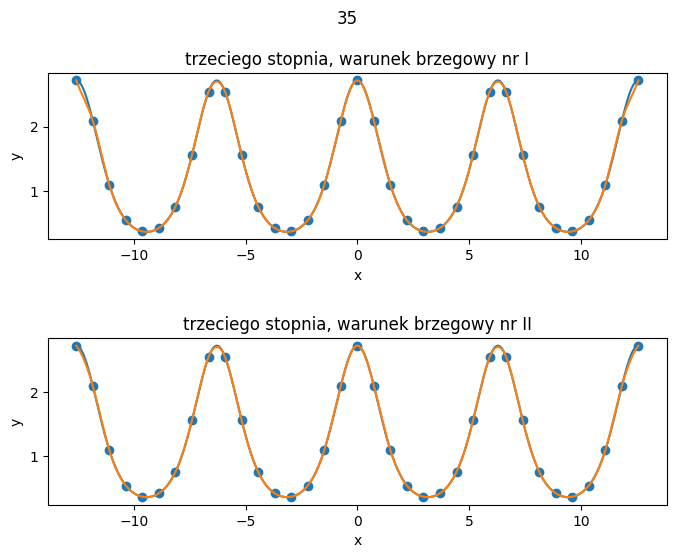

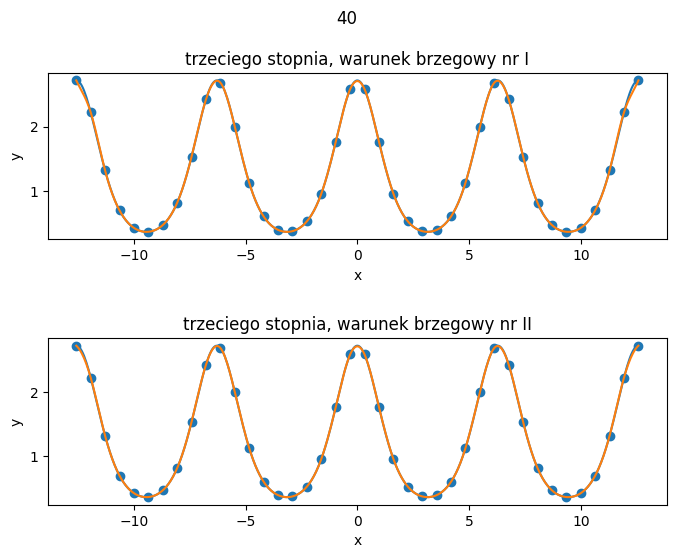

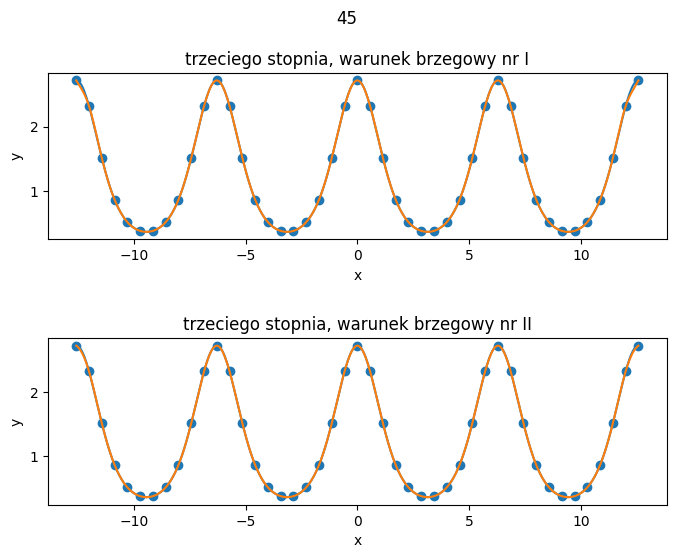

In [15]:
for i in list(range(4, 20)) + [25, 30, 35, 40, 45]:
    test_spline(i)

In [18]:
for m, e1, e2, e3, e4 in max_errors:
    print(f"{m},{e1:.5f},{e2:.5f},{e3:.5f},{e4:.5f}")

4,2.37485,21.71578,3.16673,2.63881
5,2.35040,2.35040,2.35040,2.35040
6,2.40163,3.13400,2.05244,2.39146
7,2.51991,6.31847,3.16737,3.69529
8,2.22208,7.39371,4.33459,3.75668
9,0.81557,6.65655,8.27500,7.68825
10,1.29919,4.46115,2.45509,1.87405
11,1.06268,2.76663,0.91156,1.47817
12,0.85263,1.78152,0.87636,0.97025
13,0.33158,1.58175,0.81719,1.34511
14,0.65995,1.44167,0.74300,1.11820
15,0.56488,1.15140,0.88474,1.36409
16,0.48407,0.91861,1.59209,1.13812
17,0.35808,0.76004,4.08834,3.65939
18,0.34229,0.65193,1.17108,0.76572
19,0.31781,0.57292,0.46218,0.84422
25,0.17741,0.31751,0.99252,0.72552
30,0.10553,0.20008,0.06599,0.25138
35,0.06295,0.12793,0.05323,0.20916
40,0.03857,0.09249,0.01933,0.13674
45,0.02444,0.07018,0.01065,0.10816
50,0.01620,0.05499,0.00795,0.08537


In [19]:
for m, e1, e2, e3, e4 in std_errors:
    print(f"{m},{e1:.5f},{e2:.5f},{e3:.5f},{e4:.5f}")

4,0.04735,0.51318,0.06222,0.05135
5,0.07457,0.07457,0.07457,0.07457
6,0.04826,0.06428,0.05410,0.04892
7,0.04883,0.11355,0.06604,0.06825
8,0.03570,0.11895,0.08741,0.07034
9,0.01848,0.10570,0.17591,0.15947
10,0.02241,0.06119,0.05341,0.03666
11,0.01703,0.03162,0.02488,0.03103
12,0.01308,0.02357,0.01710,0.01958
13,0.00808,0.01963,0.02099,0.02715
14,0.01054,0.01748,0.01671,0.01881
15,0.00967,0.01380,0.02117,0.02633
16,0.00862,0.01094,0.03646,0.02371
17,0.00411,0.00622,0.08151,0.06966
18,0.00637,0.00723,0.02827,0.01707
19,0.00535,0.00602,0.01273,0.01782
25,0.00178,0.00252,0.01993,0.01305
30,0.00106,0.00165,0.00136,0.00632
35,0.00056,0.00102,0.00077,0.00515
40,0.00031,0.00067,0.00034,0.00385
45,0.00018,0.00046,0.00018,0.00326
50,0.00011,0.00032,0.00011,0.00266
